In [9]:
import sys
sys.path.append('../reference/jax-cosmo/jax_cosmo-master/')

In [10]:
import jax
import jax.numpy as jnp 
from jax.config import config
import jax_cosmo as jc
from jax_cosmo.power import linear_matter_power, nonlinear_matter_power
import jax_cosmo.power as jcp 

# the emulator part 
from jax_cosmo.power import linear_matter_power_emu
from jax_cosmo.power import KGRID, ZGRID
config.update("jax_enable_x64", True)

import matplotlib.pylab as plt 
plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 20

In [3]:
jax.default_backend()

'cpu'

In [4]:
jax.devices()

[CpuDevice(id=0)]

In [5]:
scalefactor = 0.65
redshift = 1.0 / scalefactor - 1.0

In [6]:
print(f'The redshift is {redshift:.3f}.')

The redshift is 0.538.


In [7]:
cosmo = jc.Cosmology(sigma8=0.933523, Omega_c=0.096535, Omega_b=0.035931, h=0.816626, n_s=0.902618, 
                      w0=-1., Omega_k=0., wa=0.)

In [8]:
new_k = jnp.geomspace(1E-4, 50, 500)

# Emulator 

In [9]:
%%time
prediction = linear_matter_power_emu(cosmo, new_k, scalefactor)

CPU times: user 890 ms, sys: 497 ms, total: 1.39 s
Wall time: 757 ms


### Using JIT

In [10]:
emu_jit = jax.jit(linear_matter_power_emu)

In [11]:
%%time
prediction_jit = emu_jit(cosmo, new_k, scalefactor)

CPU times: user 1.81 s, sys: 299 ms, total: 2.11 s
Wall time: 1.52 s


In [12]:
%%time
prediction_jit = emu_jit(cosmo, new_k, scalefactor)

CPU times: user 1.06 ms, sys: 215 µs, total: 1.28 ms
Wall time: 797 µs


# Jax Cosmo

In [13]:
%%time
pklin_jax = linear_matter_power(cosmo, new_k, scalefactor)

CPU times: user 2.25 s, sys: 19.5 ms, total: 2.27 s
Wall time: 2.26 s


### Using JIT

In [14]:
jc_jit = jax.jit(linear_matter_power)

In [15]:
%%time 
pklin_jit = jc_jit(cosmo, new_k, scalefactor)

CPU times: user 2.14 s, sys: 26 ms, total: 2.17 s
Wall time: 2.12 s


In [16]:
%%time 
pklin_jit = jc_jit(cosmo, new_k, scalefactor)

CPU times: user 0 ns, sys: 1.24 ms, total: 1.24 ms
Wall time: 1.07 ms


# Calculates the Non-Linear Matter Power Spectrum

### With the Emulator

In [17]:
jcp.USE_EMU = True

In [18]:
%%time
pk_non_linear_fine_emu = nonlinear_matter_power(cosmo, new_k, scalefactor)

Using the emulator
CPU times: user 1.37 s, sys: 3.63 ms, total: 1.38 s
Wall time: 1.38 s


In [19]:
emu_nl_jit = jax.jit(nonlinear_matter_power)

In [20]:
%%time
pk_non_linear_fine_emu = emu_nl_jit(cosmo, new_k, scalefactor) 

Using the emulator
CPU times: user 5.5 s, sys: 965 ms, total: 6.47 s
Wall time: 4.64 s


In [21]:
%%time
pk_non_linear_fine_emu = emu_nl_jit(cosmo, new_k, scalefactor) 

CPU times: user 2.5 ms, sys: 285 µs, total: 2.79 ms
Wall time: 1.58 ms


### Without the Emulator

In [22]:
jcp.USE_EMU = False

In [23]:
%%time
pk_non_linear_fine_jax = nonlinear_matter_power(cosmo, new_k, scalefactor)

Not using the emulator
CPU times: user 3.37 s, sys: 0 ns, total: 3.37 s
Wall time: 3.34 s


In [24]:
jc_nl_jit = jax.jit(nonlinear_matter_power)

In [25]:
%%time
pk_non_linear_fine_jax = emu_nl_jit(cosmo, new_k, scalefactor) 

CPU times: user 1.57 ms, sys: 203 µs, total: 1.77 ms
Wall time: 996 µs


In [26]:
%%time
pk_non_linear_fine_jax = emu_nl_jit(cosmo, new_k, scalefactor) 

CPU times: user 1.49 ms, sys: 166 µs, total: 1.66 ms
Wall time: 972 µs


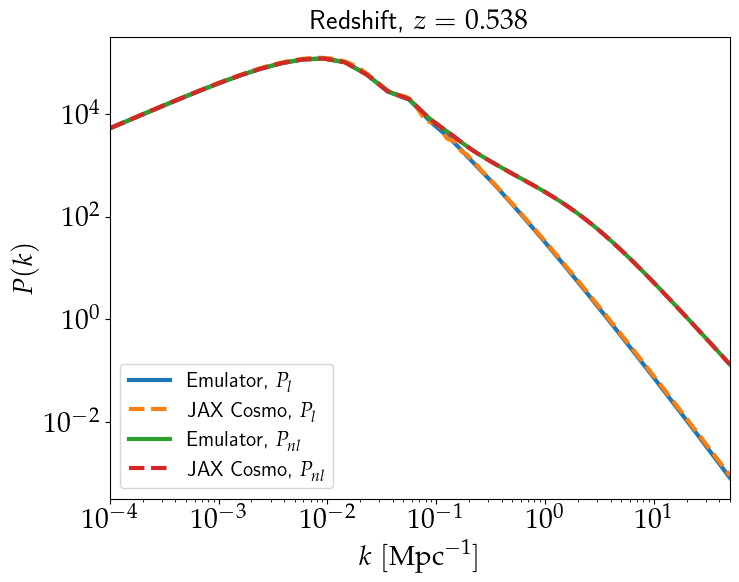

In [27]:
plt.figure(figsize = (8,6))
plt.title(f'Redshift, $z={redshift:.3f}$', fontsize=fontSize)
plt.loglog(new_k, prediction, label = 'Emulator, $P_{l}$', lw = 3)
plt.loglog(new_k, pklin_jax, lw = 3, linestyle = '--', label = 'JAX Cosmo, $P_{l}$')
plt.loglog(new_k, pk_non_linear_fine_emu, label = 'Emulator, $P_{nl}$', lw = 3)
plt.loglog(new_k, pk_non_linear_fine_jax, lw = 3, linestyle = '--', label = 'JAX Cosmo, $P_{nl}$')
plt.xlim(min(KGRID), max(KGRID))
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.ylabel(r'$P(k)$', fontsize = fontSize)
plt.xlabel(r'$k\;[\textrm{Mpc}^{-1}]$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.show()

# Blackjax

In [1]:
import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
import numpy as np
import blackjax
import pandas as pd 

In [2]:
observed = np.random.normal(10, 20, size=1_000)

In [3]:
def logdensity_fn(x):
    logpdf = stats.norm.logpdf(observed, x["loc"], x["scale"])
    return jnp.sum(logpdf)

In [4]:
# Build the kernel
step_size = 1e-3
nsamples = 20_000
burnin = int(0.1 * nsamples)
inverse_mass_matrix = jnp.array([1., 1.])
nuts = blackjax.nuts(logdensity_fn, step_size, inverse_mass_matrix)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [5]:
# Initialize the state
initial_position = {"loc": 1., "scale": 2.}
state = nuts.init(initial_position)

# Iterate
rng_key = jax.random.PRNGKey(0)
step = jax.jit(nuts.step)
record = []
for i in range(nsamples):
    rng_key, nuts_key = jax.random.split(rng_key)
    state, _ = step(nuts_key, state)
    position = state.position
    record.append({k: position[k].item() for k in position.keys()})

In [6]:
df = pd.DataFrame(record)

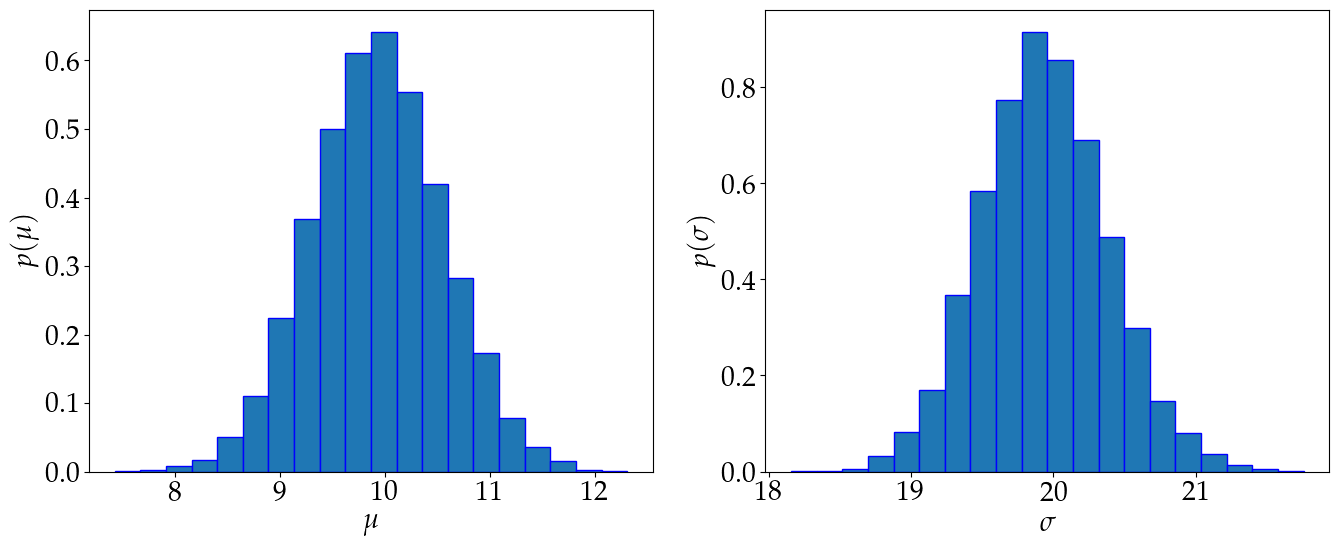

In [11]:
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.hist(df['loc'].values[burnin:], density = True, bins=20, ec='blue')
plt.ylabel(r'$p(\mu)$', fontsize = fontSize)
plt.xlabel(r'$\mu$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.subplot(122)
plt.hist(df['scale'].values[burnin:], density = True, bins=20, ec='blue')
plt.ylabel(r'$p(\sigma)$', fontsize = fontSize)
plt.xlabel(r'$\sigma$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.show()

### Pathfinder

In [12]:
def logdensity_fn_arr(x):
    logpdf = stats.norm.logpdf(observed, x[0], x[1])
    return jnp.sum(logpdf)

In [13]:
rng_key = jax.random.PRNGKey(314)
w0 = jnp.array([5.0, 15.0])
_, info = blackjax.vi.pathfinder.approximate(rng_key, logdensity_fn_arr, w0, ftol=1e-4)
path = info.path

In [ ]:
steps = (jnp.isfinite(path.elbo)).sum()

In [63]:
for i in range(steps):
    state = jax.tree_map(lambda x: x[i], path)
    sample_state, _ = blackjax.vi.pathfinder.sample(rng_key, state, 10_000)
    mu_i, cov_i = sample_state.mean(0), jnp.cov(sample_state, rowvar=False)
    print(mu_i)
    print(cov_i)
    print('-'*50)

[-19.72939    -49.30789492]
[[1.00353861 0.01218204]
 [0.01218204 0.98710199]]
--------------------------------------------------
[ 8.99963923 27.89089393]
[[0.15598146 0.01019121]
 [0.01019121 0.13371617]]
--------------------------------------------------
[ 7.23253425 31.33778668]
[[ 0.64359611 -0.05776771]
 [-0.05776771  0.61452244]]
--------------------------------------------------
[ 9.62997934 22.1048896 ]
[[ 0.39900696 -0.0343979 ]
 [-0.0343979   0.33440778]]
--------------------------------------------------
[10.7300858  19.44824855]
[[ 0.30582398 -0.02501066]
 [-0.02501066  0.20443823]]
--------------------------------------------------


### Periodic Orbital MCMC

In [65]:
import blackjax.mcmc.integrators as integrators
from blackjax import orbital_hmc as orbital

In [71]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    """Sequantially draws samples given the kernel of choice."""

    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

In [86]:
def plot_contour(logdensity, orbits=None, weights=None):
    """Contour plots for density w/ or w/o samples."""
    a, b, c, d = 8.0, 13.0, 18.0, 23.0
    x1 = jnp.linspace(a, b, 1000)
    x2 = jnp.linspace(c, d, 1000)
    ref = logdensity({"x1": 10, "x2": 20})
    y = jax.vmap(
        jax.vmap(lambda x1, x2: jnp.exp(logdensity({"x1": x1, "x2": x2})-ref), (0, None)),
        (None, 0),
    )(x1, x2)
    fig, ax = plt.subplots(1, 2, figsize=(17, 6))
    CS0 = ax[0].contour(x1, x2, y, levels=10, colors="k")
    plt.clabel(CS0, inline=1, fontsize=10)
    CS1 = ax[1].contour(x1, x2, y, levels=10, colors="k")
    plt.clabel(CS1, inline=1, fontsize=10)
    if orbits is not None:
        ax[0].set_title("Unweighted samples")
        ax[0].scatter(orbits["x1"], orbits["x2"], marker=".")
        ax[1].set_title("Weighted samples")
        ax[1].scatter(orbits["x1"], orbits["x2"], marker=".", alpha=weights)

In [66]:
def logdensity_fn_x1x2(x1, x2):
    logpdf = stats.norm.logpdf(observed, x1, x2)
    return jnp.sum(logpdf)

In [67]:
logdensity = lambda x: logdensity_fn_x1x2(**x)

In [136]:
inv_mass_matrix = jnp.ones(2)
period = 2
step_size = 0.5
initial_position = {"x1": 10.0, "x2": 20.0}

In [137]:
init_fn, vv_kernel = orbital(
    logdensity, step_size, inv_mass_matrix, period, bijection=integrators.mclachlan
)
initial_state = init_fn(initial_position)
vv_kernel = jax.jit(vv_kernel)

In [138]:
rng_key = jax.random.PRNGKey(0)
states = inference_loop(rng_key, vv_kernel, initial_state, 10_000)

samples = states.positions
weights = states.weights

In [141]:
weights

Array([[nan, nan],
       [nan, nan],
       [nan, nan],
       ...,
       [nan, nan],
       [nan, nan],
       [nan, nan]], dtype=float64)

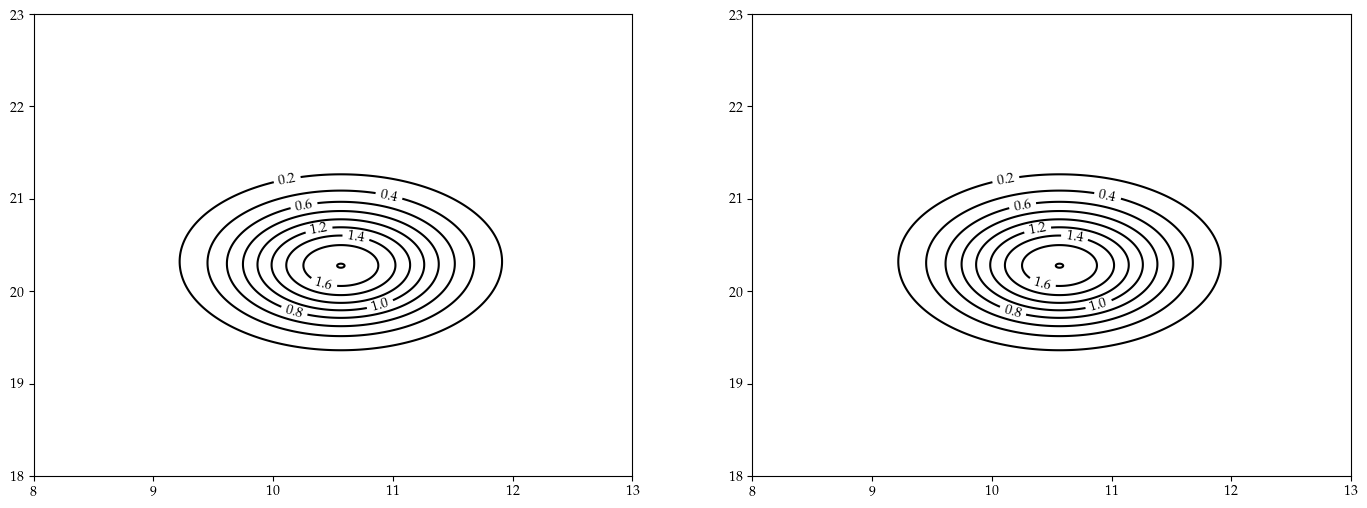

In [139]:
plot_contour(logdensity)

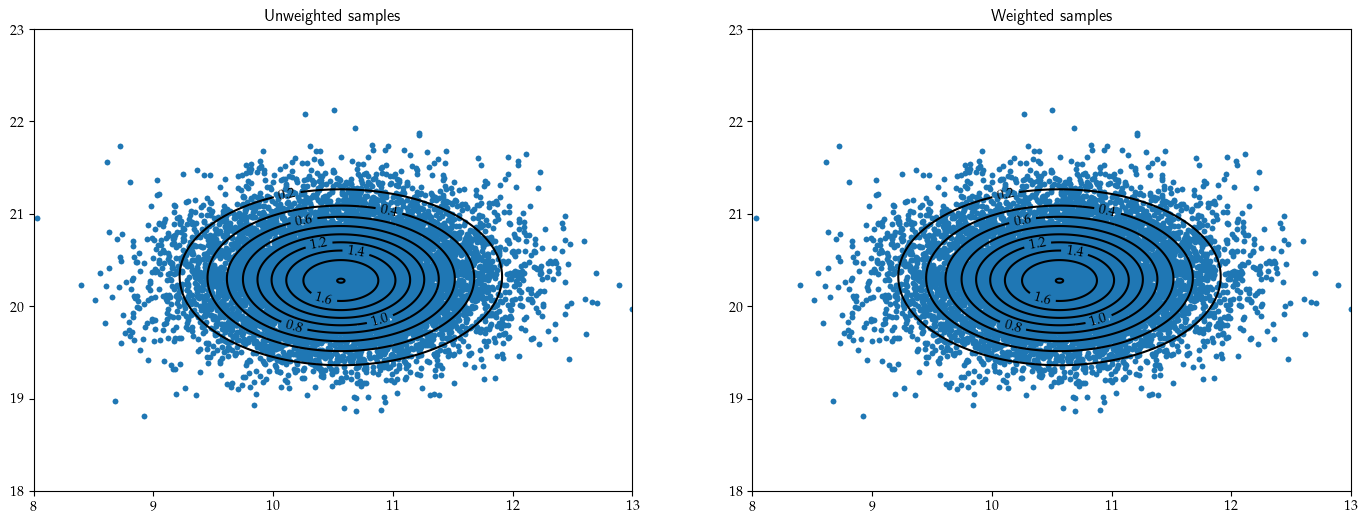

In [140]:
plot_contour(logdensity, orbits=samples, weights=None)

# Numpyro

In [61]:
import jax
# from jax.experimental import mesh_utils
# from jax.sharding import PositionalSharding
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, init_to_value

In [81]:
ref_params = {'m1': 0.0, 'm2': 0.0, 'm3': 0.0}

In [82]:
X = np.random.randn(128, 3)
y = np.random.randn(128)

def model(X, y):
    # beta = numpyro.sample("beta", dist.Normal(0, 1).expand([3]))
    # beta = numpyro.sample("beta", dist.Normal(0.012, 0.023).expand([3]))
    m1 = numpyro.sample("m1", dist.Normal(0.012, 0.023))
    m2 = numpyro.sample("m2", dist.Normal(0.012, 0.023))
    m3 = numpyro.sample("m3", dist.Normal(0.012, 0.023))
    beta = jnp.array([m1, m2, m3])
    print(beta)
    numpyro.sample("obs", dist.Normal(X @ beta, 1), obs=y)

mcmc = MCMC(NUTS(model, init_strategy=init_to_value(values=ref_params)), num_warmup=10, num_samples=1000)

# # See https://jax.readthedocs.io/en/latest/notebooks/Distributed_arrays_and_automatic_parallelization.html
# sharding = PositionalSharding(mesh_utils.create_device_mesh((8,)))
# X_shard = jax.device_put(X, sharding.reshape(8, 1))
# y_shard = jax.device_put(y, sharding.reshape(8))
# mcmc.run(jax.random.PRNGKey(0), X_shard, y_shard)

In [83]:
# [ 1.39441888 -0.38114053  0.38801493]

In [84]:
%%time
mcmc.run(jax.random.PRNGKey(124545), X, y)

[0. 0. 0.]
Traced<ConcreteArray([0. 0. 0.], dtype=float64)>with<JVPTrace(level=2/0)> with
  primal = Array([0., 0., 0.], dtype=float64)
  tangent = Traced<ShapedArray(float64[3])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float64[3]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7fbd4385b0c0>, in_tracers=(Traced<ShapedArray(float64[1]):JaxprTrace(level=1/0)>, Traced<ShapedArray(float64[1]):JaxprTrace(level=1/0)>, Traced<ShapedArray(float64[1]):JaxprTrace(level=1/0)>), out_tracer_refs=[<weakref at 0x7fbd2022c5e0; to 'JaxprTracer' at 0x7fbd2022cb30>], out_avals=[ShapedArray(float64[3])], primitive=concatenate, params={'dimension': 0}, effects=set(), source_info=SourceInfo(traceback=<jaxlib.xla_extension.Traceback object at 0x7fbd2022a1b0>, name_stack=NameStack(stack=(Transform(name='jvp'),))))


  0%|                                                                                                                                      | 0/1010 [00:00<?, ?it/s]

Traced<ShapedArray(float64[3])>with<JVPTrace(level=5/0)> with
  primal = Traced<ShapedArray(float64[3])>with<DynamicJaxprTrace(level=3/0)>
  tangent = Traced<ShapedArray(float64[3])>with<JaxprTrace(level=4/0)> with
    pval = (ShapedArray(float64[3]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7fbd31b971a0>, in_tracers=(Traced<ShapedArray(float64[1]):JaxprTrace(level=4/0)>, Traced<ShapedArray(float64[1]):JaxprTrace(level=4/0)>, Traced<ShapedArray(float64[1]):JaxprTrace(level=4/0)>), out_tracer_refs=[<weakref at 0x7fbd2032fb80; to 'JaxprTracer' at 0x7fbd2032f180>], out_avals=[ShapedArray(float64[3])], primitive=concatenate, params={'dimension': 0}, effects=set(), source_info=SourceInfo(traceback=<jaxlib.xla_extension.Traceback object at 0x7fbd20475cb0>, name_stack=NameStack(stack=(Transform(name='jvp'),))))


sample: 100%|████████████████████████████████████████████████████████████████████████| 1010/1010 [00:01<00:00, 667.15it/s, 3 steps of size 2.46e-02. acc. prob=0.83]


CPU times: user 1.72 s, sys: 14.8 ms, total: 1.73 s
Wall time: 1.72 s


In [85]:
beta_samples = mcmc.get_samples()

In [86]:
beta_samples

{'m1': Array([ 4.15297539e-02,  1.31590160e-02,  3.15311650e-02,  3.26960864e-02,
         3.26960864e-02,  4.50017961e-03,  2.01684803e-02,  1.19669637e-03,
         1.56721100e-02,  3.02924951e-02,  4.62291707e-03,  3.28566653e-02,
         2.35194203e-02, -1.34065277e-02,  2.59639244e-02, -1.10993590e-02,
         2.36202076e-02,  1.60431642e-02,  6.87975200e-03,  3.17416697e-02,
         8.87975857e-03, -6.80138892e-03,  2.56936258e-02,  5.68358826e-02,
         2.00507388e-03,  6.43491665e-03,  3.95272837e-02, -8.62743810e-03,
         3.53531664e-02, -2.18496072e-02,  3.77207781e-02, -1.66194123e-02,
         4.34802160e-02, -2.15380461e-02, -2.45638389e-02, -3.62878369e-02,
         3.18968916e-02, -2.91801068e-02,  2.94122934e-02,  4.45058161e-02,
         5.15297409e-03, -3.71771393e-03,  2.68300338e-02,  3.91567037e-03,
         1.30718729e-02,  1.09662356e-03,  6.45577427e-03,  3.58427584e-02,
         1.00354667e-02, -1.08451289e-02,  8.40196041e-03,  1.15127875e-02,
      

In [87]:
def normal_distribution(mean, std):
    import scipy.stats as ss 
    xrange = np.linspace(mean - 5* std, mean + 5 * std, 1000)
    distribution = ss.norm(mean, std)
    pdf = distribution.pdf(xrange)
    return xrange, pdf

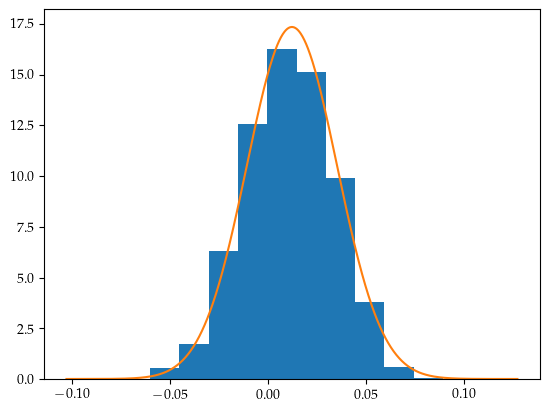

In [88]:
plt.figure()
plt.hist(beta_samples['m1'], density=True)
x, p = normal_distribution(0.012, 0.023)
plt.plot(x, p)
plt.show()

In [89]:
import scipy.stats as ss 

In [90]:
distribution = ss.multivariate_normal(np.ones(2), np.eye(2))

In [91]:
vec = np.random.randn(2)

In [92]:
distribution.logpdf(vec)

-4.381953536161102

In [93]:
factor = 5

In [94]:
distribution2 = ss.multivariate_normal(factor*np.ones(2), np.eye(2)*factor**2)

In [95]:
distribution2.logpdf(vec*factor)

-7.6008293610293025

In [96]:
def pdf(x, mean, cov):
    return np.exp(logpdf(x, mean, cov))


def logpdf(x, mean, cov):
    # `eigh` assumes the matrix is Hermitian.
    vals, vecs = np.linalg.eigh(cov)
    logdet     = np.sum(np.log(vals))
    valsinv    = np.array([1./v for v in vals])
    # `vecs` is R times D while `vals` is a R-vector where R is the matrix 
    # rank. The asterisk performs element-wise multiplication.
    U          = vecs * np.sqrt(valsinv)
    rank       = len(vals)
    dev        = x - mean
    # "maha" for "Mahalanobis distance".
    maha       = np.square(np.dot(dev, U)).sum()
    log2pi     = np.log(2 * np.pi)
    return -0.5 * (rank * log2pi + maha + logdet)

In [99]:
cov = np.random.randn(2,2)
cov = cov @ cov.T

In [103]:
vals, vecs = np.linalg.eigh(cov)
logdet     = np.sum(np.log(vals))
valsinv    = np.array([1./v for v in vals])
# `vecs` is R times D while `vals` is a R-vector where R is the matrix 
# rank. The asterisk performs element-wise multiplication.
U          = vecs * np.sqrt(valsinv)
rank       = len(vals)

In [106]:
x = np.random.randn(2)
mean = np.zeros(2)
dev = x - mean

In [107]:
dev

array([-1.01925428,  1.24844656])

In [108]:
np.dot(dev, U)

array([1.87755161, 1.0032876 ])

In [110]:
jax.scipy.stats.uniform.logpdf(jnp.ones(1), 0, 2)

Array([-0.69314718], dtype=float64)

In [111]:
jax.scipy.stats.norm.logpdf(jnp.zeros(1), 0, 1)

Array([-0.91893853], dtype=float64)

In [112]:
import scipy.stats as ss 

In [113]:
ss.norm(0, 1).logpdf(0)

-0.9189385332046727